# Predict Air Pollution

#### Pedagogical objectives
- Prepare the data (for real)
- Further dig into Recurrent Neural Networks
- Stack multiple layers of RNNs

#### ML objective
- predict the **air pollution on the next day**
- given a sequence of weather features, such as the temperature, the pression, etc..
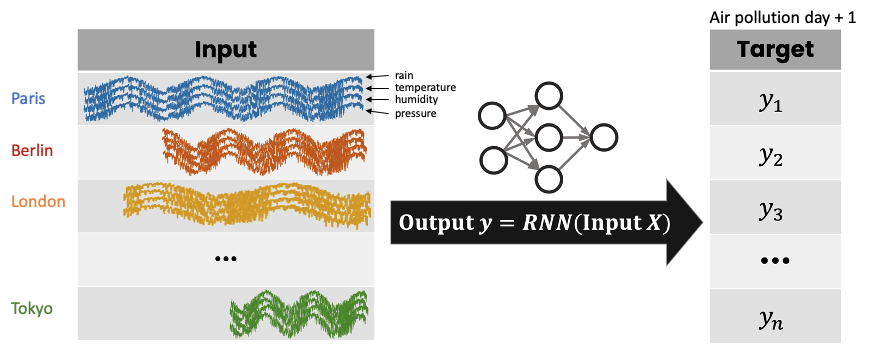

## 1. Preprocessing

### 1.1 Load and inspect data

In [2]:
!pip install pandas

     --------------------------------------- 10.3/10.3 MB 29.7 MB/s eta 0:00:00
  Using cached pytz-2022.7.1-py2.py3-none-any.whl (499 kB)



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...,...
43820,8.0,-2.0,-23,1034.0,0,0,231.97
43821,10.0,-3.0,-22,1034.0,0,0,237.78
43822,10.0,-3.0,-22,1034.0,0,0,242.70


☝️ The data here corresponds to hourly measurements of the air pollution (feature: `pm2.5`, which is the concentration of 2.5 millimeter particles) that you will try to predict. Among the other related features, you have:
- TEMP: Temperature
- DEWP: Dew Point
- PRES: Pressure
- Ir: Cumulated hours of rain
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow

❓ **Question** ❓ Plot the temporal progression of the different variables to get an intuition about the problem. How many years of data do we have? Are some feature visually correlated with the target?

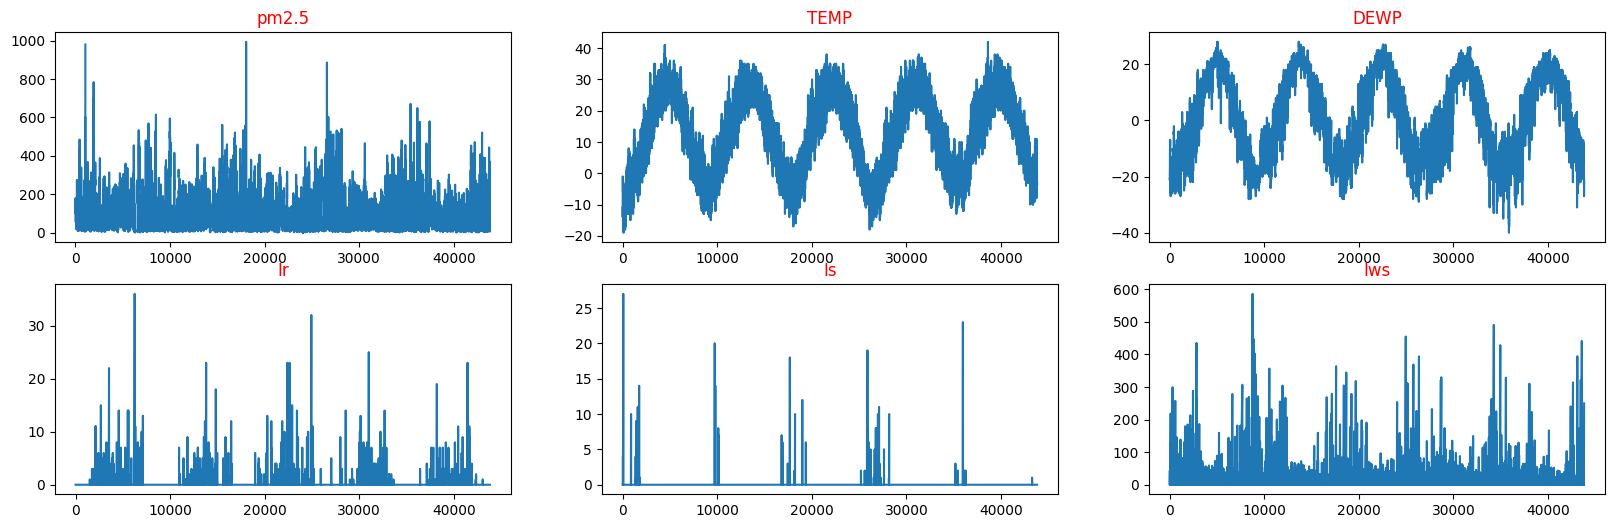

In [14]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(20, 6))
axes[0, 0].plot(df['pm2.5']), axes[0, 0].set_title("pm2.5", c="r")
axes[0, 1].plot(df['TEMP']), axes[0, 1].set_title("TEMP", c="r")
axes[0, 2].plot(df['DEWP']), axes[0, 2].set_title("DEWP", c="r")
axes[1, 0].plot(df['Ir']), axes[1, 0].set_title("Ir", c="r")
axes[1, 1].plot(df['Is']), axes[1, 1].set_title("Is", c="r")
axes[1, 2].plot(df['Iws']), axes[1, 2].set_title("Iws", c="r")
plt.show()

### 1.2 Create sequences (`X`,`y`) 

In the previous exercises, we had multiple independent data sequences. Here, you notice that there is only one. And this is quite often the case. So how to deal with such data? In fact, this long sequence can be separated in a lot of short sequences that we will consider as independent. 
![image.png](attachment:image.png)

This section aims to create a training set suitable for a RNN:
```python
X.shape = (n_sequences, length, n_features) # e.g. (100, 20, 7)
y.shape = (n_sequences, ) # e.g. (100,)
```

❓ **Question** ❓ Code the function `subsample_sequence` below such that it returns something like
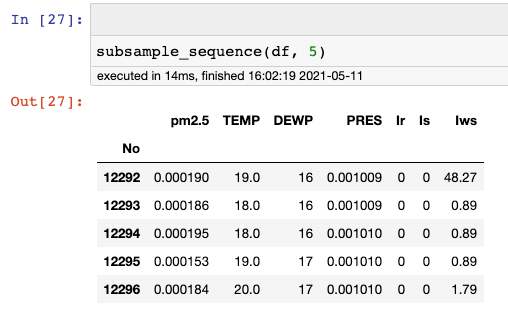

In [15]:
len(df)

43824

In [16]:
df.shape

(43824, 7)

In [26]:
import numpy as np
import random

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    pass  # YOUR CODE HERE
    df_ = df.copy()
    where =range(df_.shape[0])
    sample = random.randint(where.start, where.stop-length)
    df_sample = df_.iloc[sample:sample+length, :]
    return df_sample

In [27]:
# Test it 
assert subsample_sequence(df, 10).shape == (10, 7)
assert subsample_sequence(df, 40000).shape == (40000, 7)

❓ **Question** ❓ Write a function that given a full dataframe `df`:
- Subsamples this dataset into a shorter sequence of length `length`
- Stores the value of the pollution of the last day as your variable array `y`
- Stores all features of previous days as a variable `X`
- Returns (`X`, `y`)


In [29]:
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    pass  # YOUR CODE HERE
    df_= df.copy()
    sample = subsample_sequence(df_, length)
    y_sample = sample['pm2.5'].iloc[-1]
    X_sample = sample.iloc[:-1]
    return np.array(X_sample), np.array(y_sample)

In [30]:
# Test it
(X_sample, y_sample) = split_subsample_sequence(df, 10)
assert X_sample.shape == (9,7)
assert y_sample.shape == ()

🚨 There are missing values in the dataframe. Let's deal with it: 

- If the value to predict `y` is missing, the function should re-run.
- If there are missing values in the variables `X`, then it should be replaced by the mean values over the other selected hours. 
- If all the other hours are missing, then they should all be replaced by the mean value of the dataframe.

❓ **Question (HARD)** ❓ Try to update your function above taking this into account. Use the solution below if you don't find the answer.


<details>
    <summary>🆘  solution </summary>
    

```python
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['pm2.5']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)
```
</details>

In [32]:
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    pass # YOUR CODE HERE
    #If the value to predict y is missing, the function should re-run
    while True:
        sample = subsample_sequence(df, length)
        X_sample = sample.iloc[:-1]
        y_sample = sample["pm2.5"].iloc[-1]

        if np.isnan(y_sample): continue
        X_sample = X_sample.apply(lambda x: x.fillna(np.nanmean(x)), axis=0)
        if np.isnan(X_sample.values).sum() != 0: continue

        return np.array(X_sample), np.array(y_sample)


❓ **Question** ❓ Write a last (!) function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

In [48]:
def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    pass  # YOUR CODE HERE

    return X, y

❓ **Question** ❓ Generate your dataset $(X, y)$ of `2000` sequences, each of `20` observations + the value of the pollution at the 21-st day to predict. That's about 40,000 observations, roughly equivalent to our dataset

In [49]:
# YOUR CODE HERE

In [51]:
# Check your code below
assert X.shape == (2000, 20, 7)
assert y.shape == (2000, )
assert np.isnan(X).sum() == 0

### 1.3 Train Test Split

🚨 **IMPORTANT REMARK: POTENTIAL DATA LEAKAGE** 🚨 If you split this dataset (X, y) into a training and a test set, it is much likely that some data in the train set are in the test set. Especially, you will predict data in test that are input data in train.

To avoid this situation, you should _first_ separate your initial dataframe `df` into a training dataframe and test dataframe as below

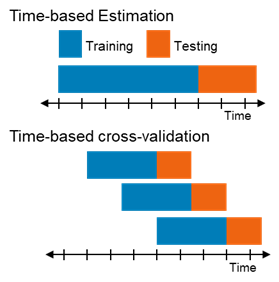


❓ **Question** ❓ Let's not cross-validate in this challenge to start with 🤯 
- Separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training, and the last 20% in the test set.
- Then generate (`X_train`, `y_train`) from `df_train` and (`X_test`, `y_test`) from `df_test`
- Ensure that `X_train.shape == (2000, 20, 7)`

In [52]:
# YOUR CODE HERE

In [54]:
assert X_train.shape == (2000, 20, 7)

## 2. Predict pollution !

❓ **Question** ❓ First, what is your benchmark prediction to beat?  
Let's measure our performance in terms of *Mean Absolute Percentage Error (MAPE)* for this Time Serie challenge!

In [55]:
# YOUR CODE HERE

### 2.1 Simple LSTM

❓ **Question** ❓ Now, let's try here with a simple single-layer `LSTM`

- Initialize a model the way you want and compile it within the `init_model` function.
- Then, **Fit** your model and evaluate it on the test data using the `mape` metric (useful in time series)

💡 Pro tips:
- Look at the scale of your feature: Scale them features if needed
- Look at the scale of your target: If smaller than usual, increase the learning rate vs. default values!
- Don't forget to plot your loss history to get visual feedback

In [56]:
# YOUR CODE HERE

### 2.3 Stack RNN layers

❓ **Question** ❓ Now that you know how to write a recurrent architecture, let's see how to stack one.
If you want to stack multiple RNN, LSTM, GRU layers, it is very easy. Do it as if they were Dense (or any other) layers.

But don't forget: All RNN (**EXCEPT** the last one) should have the `return_sequences` set to True so that the entire sequence of predictions of a given layer is given to the next layer. Otherwise, you will only give the last prediction to the next layer.

In [83]:
# YOUR CODE HERE

## 3.  Check effect of data size on performance

❓ **Question** ❓ Now, let's see how the performance changes depending on

- the number of days in each sequence (20+1 days in the previous example).
- the number of sequences (2000 sequences in our previous example)

For different values of temporal sequence lengths, re-split your data, run your model and evaluate its performance. We advise to wrap this analysis into the function below

In [65]:
def train_model(nb_sequences=1000, nb_days=50, plot_history=False):
    '''returns the MAPE on the train set'''
    pass ### YOUR CODE HERE